In [66]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from PyAstronomy import pyasl
from scipy import signal
%matplotlib inline

In [67]:
# # HMM input
# for ipara in range(len(para)):
#     paramter=para[ipara]    
    
#     Tot=300
#     dt=0.01
#     T=np.arange(dt,Tot,dt)
#     G = paramter
#     w = G/(2*1.06)
#     D=4
#     L=np.zeros(len(T))
#     V=np.zeros(len(T))
#     mu, sigma = 0, 1
#     for i in range(len(T)-1):
#         L[i+1]=L[i]+V[i]*dt
#         V[i+1]=(1-G*dt)*V[i]-w**2*L[i]*dt+math.sqrt(D*dt)*np.random.normal(mu, sigma)
#     plt.plot(T,L)

In [68]:
# OU
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
tau=0.5
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)

[       -inf -1.25455124 -0.76551275 -0.36422963  0.          0.26972369
  0.60692666  1.07839961         inf]
[       -inf -1.26417834 -0.77038257 -0.36854897  0.          0.27278379
  0.61077426  1.08691991         inf]
[       -inf -1.2520752  -0.76341065 -0.36561927  0.          0.27024844
  0.60457834  1.07928631         inf]
[       -inf -1.26965717 -0.77533543 -0.36969169  0.          0.2721612
  0.61659543  1.09723417         inf]
[       -inf -1.25264798 -0.75970988 -0.37001297  0.          0.2721039
  0.60835094  1.07024245         inf]
[       -inf -1.27090748 -0.77334824 -0.3808897   0.          0.27824048
  0.62316569  1.09893756         inf]
[       -inf -1.26252519 -0.77131591 -0.3686217   0.          0.26380868
  0.60852354  1.06286524         inf]
[       -inf -1.29291153 -0.78937183 -0.38507247  0.          0.27679003
  0.63319206  1.10774385         inf]


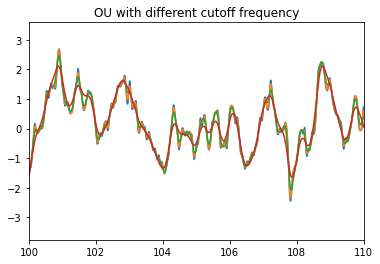

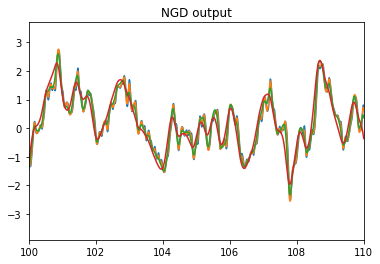

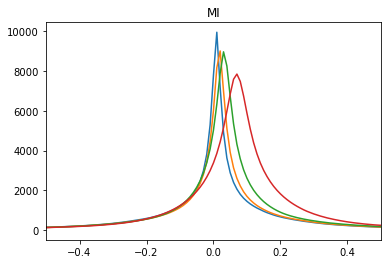

In [69]:
fc=[10,7,4,2]
mset=[1,3,6,15]
for ipara in range(len(fc)):
    b, a = signal.butter(2, 2*fc[ipara]*dt, btype='low', analog=False)
    Lf = signal.filtfilt(b, a, L)
    LfSTD = np.std(Lf)
    Lf = Lf/LfSTD
    plt.figure(num=1)
    plt.title('OU with different cutoff frequency')
    plt.plot(T,Lf)
    plt.xlim(100,110)

# UNGD output
    x=Lf
    m=mset[ipara]
    b=(3+m)/2
    FBsum=np.zeros(len(L))
    for k in range(m):
        fb=np.zeros(len(x))
        for i in range(len(x)):
            ck=(k+1)/m
            ytime=i/dt-(m-k)*dt
            ind=int(ytime*dt)
            if ind>0:
                fb[i]=ck*x[ind]
            elif ind<=0:
                fb[i]=0
        FBsum=FBsum+fb
    y=(3+m)/2*x-FBsum
    plt.figure(num=2)
    plt.title('NGD output')
    plt.plot(T,y)
    plt.xlim(100,110)
    
# assign data to different state
# state number should be even
    nx=8
    ny=8

    # states of input
    xs=x
    xs=np.sort(x)
    xstatestep=len(xs)/nx
    xinterval=[0]
    for i in range(int(nx/2-1)):
        xinterval=np.append(xinterval,xs[round(len(xs)/2)+(i+1)*round(xstatestep)])
    xinterval=np.append(xinterval,float('inf'))
    for j in range(int(nx/2-1)):
        xinterval=np.append(xs[round(len(xs)/2)-(j+1)*round(xstatestep)],xinterval)
    xinterval=np.append(float('-inf'),xinterval)
    print(xinterval)
    xstate=np.zeros(len(x))
    for i in range(len(x)):
        tempinterval=[]
        state=[]
        tempinterval=np.array(xinterval)
        tempinterval=np.append(tempinterval,x[i])
        tempinterval=np.sort(tempinterval)
        state=np.where(tempinterval==x[i])
        xstate[i]=state[0][0]

    # states of output
    ys=y
    ys=np.sort(y)
    ystatestep=len(ys)/ny
    yinterval=[0]
    for i in range(int(ny/2-1)):
        yinterval=np.append(yinterval,ys[round(len(ys)/2)+(i+1)*round(ystatestep)])
    yinterval=np.append(yinterval,float('inf'))
    for j in range(int(ny/2-1)):
        yinterval=np.append(ys[round(len(ys)/2)-(j+1)*round(ystatestep)],yinterval)
    yinterval=np.append(float('-inf'),yinterval)
    print(yinterval)
    ystate=np.zeros(len(y))
    for i in range(len(y)):
        tempinterval=[]
        state=[]
        tempinterval=np.array(yinterval)
        tempinterval=np.append(tempinterval,y[i])
        tempinterval=np.sort(tempinterval)
        state=np.where(tempinterval==y[i])
        ystate[i]=state[0][0]
        
        
# calculating mutual information
    negshift=-1 # second
    posshift=1 # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.linspace(1,nx+1,nx+1) # states of x
    yedges=np.linspace(1,ny+1,ny+1) # states of y

    # shifted data
    # shift>0 => y shifted to positive side
    MI=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros(len(xx))
        for j in range(len(xx)):
            px=px_list[int(xx[j]-1)]
            py=py_list[int(yy[j]-1)]
            pxy=pxy_list[int(xx[j]-1)][int(yy[j]-1)]
            MIsingle[j]=pxy*math.log2(pxy/px/py)
        MI[i]=np.sum(MIsingle)
    plt.figure(num=3)
    plt.title('MI')
    plt.plot(timeshift,MI)
    plt.xlim(-0.5,0.5)